In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

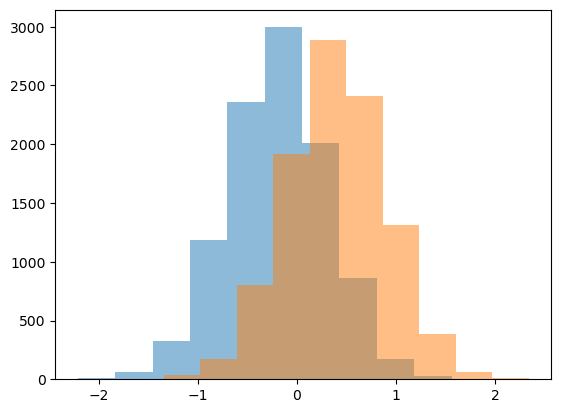

In [5]:
N=10000
x_signal=-0.2+0.5*np.random.randn(N)
y_signal=np.ones(N)
x_backgr=0.4+0.5*np.random.randn(N)
y_backgr=np.zeros(N)
plt.hist(x_signal,alpha=0.5)
plt.hist(x_backgr,alpha=0.5)
plt.show()
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [4]:
sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train.reshape(-1, 1))
x_test_scaled  = sc.transform(x_test.reshape(-1, 1))

In [6]:
features=1

torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(features, features)
)
#net[0].weight[0][1] = torch.nn.Parameter(torch.tensor([1.]), requires_grad=False)
#print(net[0].weight)
torch.save(net.state_dict(), 'net.pth')

bce_loss_fn = torch.nn.BCEWithLogitsLoss()

# loss function that allows us to optimize a cut in x to separate signal and background according
# to some metric.
# inputs: x data, NN output, y_targets
def gt_loss_fn (x, cut_value, y_true):
    # apply the NN output cut to the data
    # get y_pred from applying cut_value to x
    y_pred = torch.autograd.Variable(torch.gt(x,cut_value).float(), requires_grad=True)
    #print(zip(x, cut_value, y_pred, y_true))
    #print(x)
    #print(cut_value)
    #print(y_pred)
    #print(y_true)
    
    # calculate the BCE loss after assigning labels based on the applied cut
    # return BCE loss
    return bce_loss_fn(y_pred, y_true)

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
y_train_tensor=y_train_tensor.unsqueeze(1)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
y_test_tensor=y_test_tensor.unsqueeze(1)

In [10]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
    # we need to send the network and data to the GPU!
    net.to(device)
    x_train_tensor=x_train_tensor.to(device)
    y_train_tensor=y_train_tensor.to(device)
    x_test_tensor=x_test_tensor.to(device)
    y_test_tensor=y_test_tensor.to(device)

    
xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(y_train)/1), shuffle=True)


for epoch in range(50):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        #print(net[0].bias)
        #print(net[0].weight)
        y_pred = net(x_batch)
        #print(y_pred)
        optimizer.zero_grad()
        loss = bce_loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=bce_loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.2s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  1 in  0.4s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch  2 in  0.2s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch  3 in  0.2s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch  4 in  0.4s, Train loss=5.9e-01, Test loss=5.9e-01
Completed epoch  5 in  0.2s, Train loss=5.8e-01, Test loss=5.8e-01
Completed epoch  6 in  0.5s, Train loss=5.8e-01, Test loss=5.8e-01
Completed epoch  7 in  0.2s, Train loss=5.7e-01, Test loss=5.7e-01
Completed epoch  8 in  0.4s, Train loss=5.7e-01, Test loss=5.7e-01
Completed epoch  9 in  0.2s, Train loss=5.6e-01, Test loss=5.7e-01
Completed epoch 10 in  0.2s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch 11 in  0.4s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch 12 in  0.2s, Train loss=5.5e-01, Test loss=5.6e-01
Completed epoch 13 in  0.4s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 14 in  0.2s, Train loss=5.5e-01, Test loss=5.5

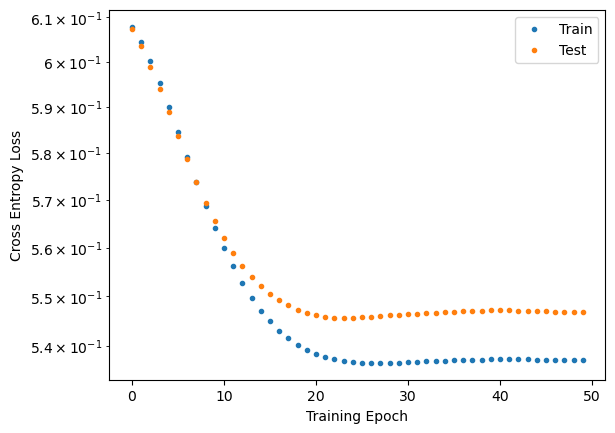

In [11]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In [12]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.sigmoid(net(x_test_tensor)).detach().cpu()
y_pred_train= torch.sigmoid(net(x_train_tensor)).detach().cpu()

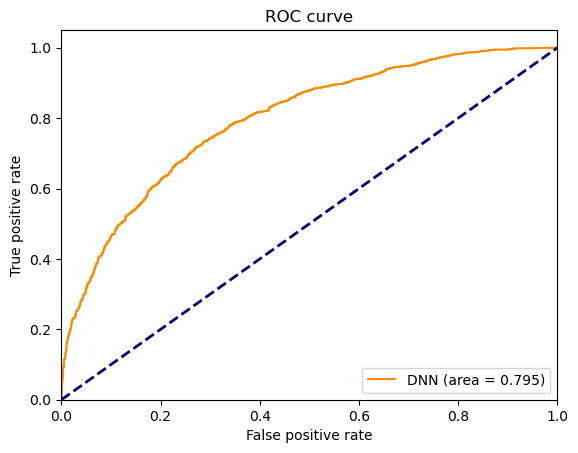

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
def ListToGraph(l,bins,color,weight=0):
    counts,bin_edges = np.histogram(l,bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    err = np.sqrt(counts)
    if weight==0:
        weight=1./(sum(counts)*(bin_edges[1]-bin_edges[0]))
    counts = weight*counts
    err = weight*err
    return plt.errorbar(bin_centres, counts, yerr=err, fmt='o',color=color)

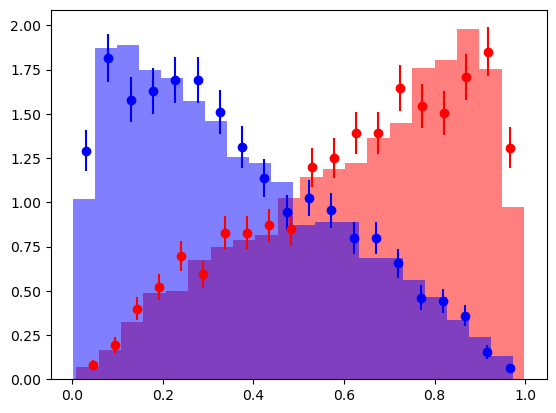

In [15]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
#plt.yscale("log")
plt.show()

In [16]:
bias=net[0].bias.detach()[0]
weight=net[0].weight.detach()[0][0]
print(bias)
print(weight)
sc.inverse_transform([[-1.*bias/weight]])

tensor(-0.0087)
tensor(-1.5160)


array([[0.10006006]])

I don't understand why the calculation above yields the optimal cut value in the un-transformed feature space, but it appears to do just that.  I would have thought it should be inverse_transform((x'' - bias)/weight).

It looks, though, like we can only either fix or not-fix the entire weight matrix, so it won't be easy to use Linear layers to train selection against multiple features.  We'll have to implement as a series of 1D transforms, and then check BCE on the sum.

# Now in more dimensions

In [6]:
N=10000 # number of points
m=10 # dimensions

In [79]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)
means_widths=np.random.randn(m,2,2)
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

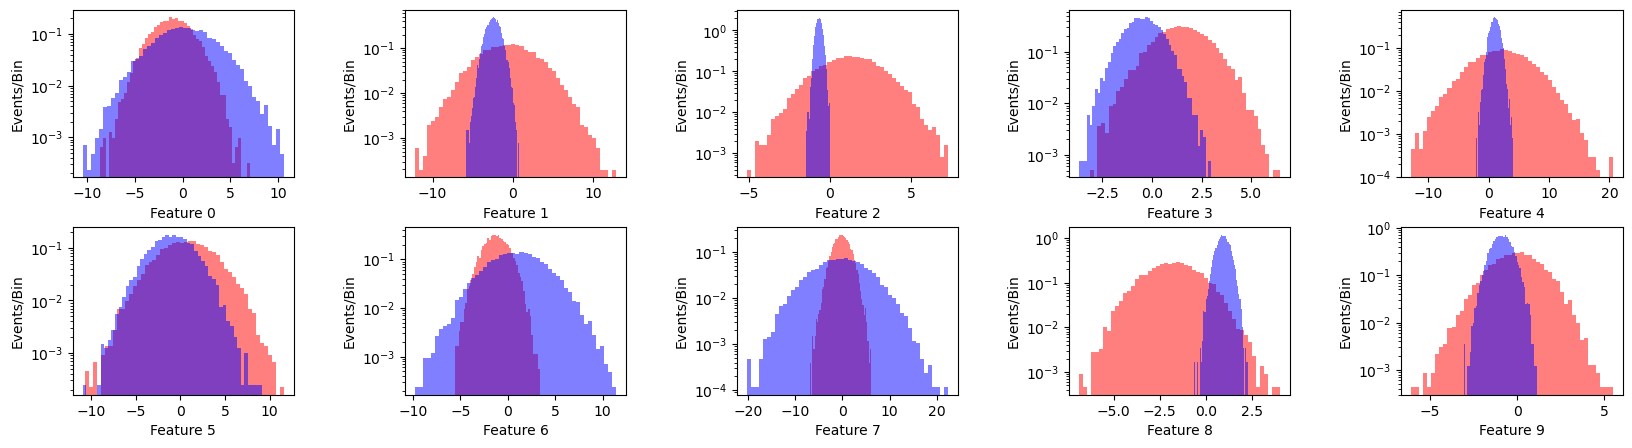

In [80]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [82]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

For this kind of network, need the 
* inputs to be our matrix of N rows (events) and m columns (features)
* weights and biases, with some shape that enables the output to be:
* outputs that give the distance of each feature from the correct classification

Ideally will have expressions like (this is not real matrix algebra, unfortunately, but if only we could cheat):

$$
\begin{bmatrix}
x_{1}\\
...\\
x_{m}
\end{bmatrix}
\begin{bmatrix}
w_{1} & ... & w_{m}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
y_{1} & ... &y_{m}
\end{bmatrix}
$$

For a large group of events:

$$
\begin{bmatrix}
w_{1}\\
...\\
w_{m}
\end{bmatrix}
\begin{bmatrix}
x_{11} & ... & x_{1m}\\
... & ... & ...\\
x_{N1} & ... & x_{Nm}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
(w_{1}x_{11}+b_{1}) & ... &(w_{m}x_{1m}+b_{m})\\
... & ... & ...\\
(w_{1}x_{N1}+b_{1}) & ... &(w_{m}x_{Nm}+b_{m})
\end{bmatrix}
=
\begin{bmatrix}
y_{11} & ... &y_{1m}\\
... & ... & ...\\
y_{N1} & ... &y_{Nm}
\end{bmatrix}
$$

Then we need a way to calculate a single "score" based on the $y$ values for a given event.  Could be some distance in the $m$-dimensional feature space (1-norm or 2-norm), or just whether it failed a single cut or not, etc.

In [83]:
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F

class OneToOneLinear(torch.nn.Module):

    __constants__ = ['features']
    features: int
    weight: Tensor

    def __init__(self, features: int, 
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.features = features
        self.weight = Parameter(torch.empty(features, **factory_kwargs))
        self.bias = Parameter(torch.empty(features, **factory_kwargs))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound=1./math.sqrt(self.features)
        torch.nn.init.uniform_(self.weight, -bound, bound)
        torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:

        # need to turn the "weights" vector into a matrix with the vector 
        # elements on the diagonal, and zeroes everywhere else.
        targets = torch.matmul(input,torch.diag(self.weight))+self.bias
        return targets

        ## return the sum over all the targets.  doesn't really matter if we normalize
        ## by the number of features, but that seems to help a bit, maybe because of the
        ## saturation of the sigmoid activation in the loss.
        # return torch.sum(targets,1)/self.features # 1-norm

        ## sum in quadrature, gives similar results to a simple sum
        # return torch.sqrt(torch.sum(torch.square(targets),1))/self.features

        ## this doesn't really work well
        # out, inds = torch.max(targets,dim=1)
        # return out

    def extra_repr(self) -> str:
        return f'in_features={self.features}, bias={self.bias}'

class OneToOneLinearActivation(torch.nn.Module):
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super().__init__()
        self.inplace = inplace

    def forward(self, input: Tensor) -> Tensor:
        # this is a bit steeper than sigmoid
        return (torch.tanh(input)+1.)/2.

        # this also works
        #return torch.sigmoid(input)

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str
    

In [124]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    OneToOneLinear(m),
    OneToOneLinearActivation()
)

torch.save(net.state_dict(), 'net.pth')

# net_outputs in this case is a list of output scores for each event, one score per input features.
# need to try to push these towards 1 for signal, and 0 for background.
def outputs_to_labels(net_outputs, features):
    # try an infinity norm
    targets=torch.max(torch.abs(net_outputs),1,keepdim=True).values.squeeze(1)
    #print(targets)
    #print(torch.sum(net_outputs,1)/features)
    return targets
    #return torch.linalg.vector_norm(net_outputs,float('inf'))
    
    # do the silly thing and sum over all the outputs.  each output weighted the same,
    # misclassification contributes to a larger loss value.
    #return torch.sum(net_outputs,1)/features
    
    ## there's no variation on this that seems to work well. 
    ## loss function is capped within a range less than [0,1], or get errors.
    # return torch.sqrt(torch.sum(torch.square(net_outputs,1))/features

bce_loss_fn = torch.nn.BCELoss()
def loss_fn (y_pred, y_true, features):
    return bce_loss_fn(outputs_to_labels(y_pred,features),y_true)

In [133]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
batch_size=int(len(y_train)/1) # one batch
epochs=50

In [134]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor, m)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.4s, Train loss=7.5e-01, Test loss=9.1e-01
Completed epoch  1 in  0.3s, Train loss=9.2e-01, Test loss=6.8e-01
Completed epoch  2 in  0.7s, Train loss=6.7e-01, Test loss=4.6e-01
Completed epoch  3 in  0.3s, Train loss=4.6e-01, Test loss=2.8e-01
Completed epoch  4 in  0.4s, Train loss=2.8e-01, Test loss=1.8e-01
Completed epoch  5 in  0.7s, Train loss=1.7e-01, Test loss=1.2e-01
Completed epoch  6 in  0.5s, Train loss=1.2e-01, Test loss=9.8e-02
Completed epoch  7 in  0.5s, Train loss=1.0e-01, Test loss=8.9e-02
Completed epoch  8 in  0.3s, Train loss=9.1e-02, Test loss=8.3e-02
Completed epoch  9 in  0.8s, Train loss=8.5e-02, Test loss=7.7e-02
Completed epoch 10 in  0.4s, Train loss=7.9e-02, Test loss=7.2e-02
Completed epoch 11 in  0.4s, Train loss=7.3e-02, Test loss=6.7e-02
Completed epoch 12 in  0.3s, Train loss=6.8e-02, Test loss=6.2e-02
Completed epoch 13 in  0.6s, Train loss=6.3e-02, Test loss=5.8e-02
Completed epoch 14 in  0.4s, Train loss=5.9e-02, Test loss=5.4

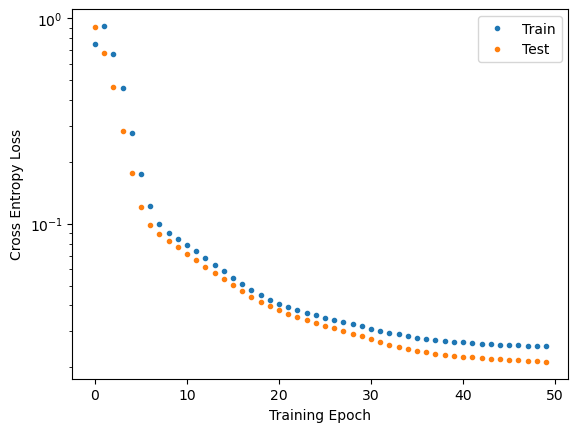

In [135]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

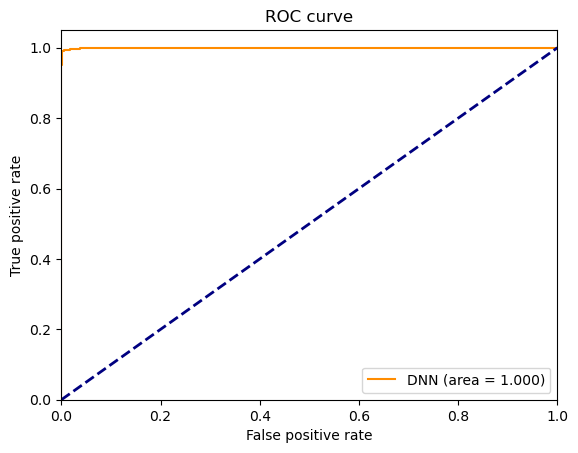

In [136]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = outputs_to_labels(net(x_test_tensor),m).detach().cpu()
y_pred_train= outputs_to_labels(net(x_train_tensor),m).detach().cpu()

fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

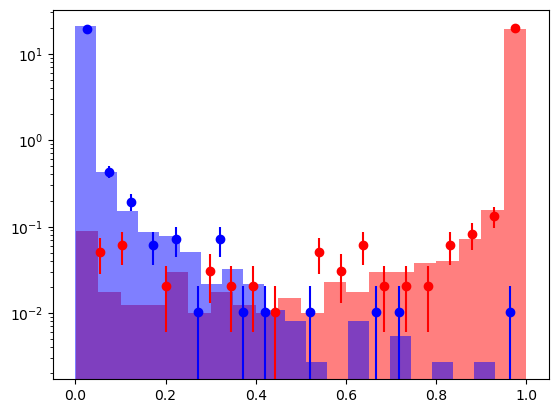

In [137]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
plt.yscale("log")
plt.show()

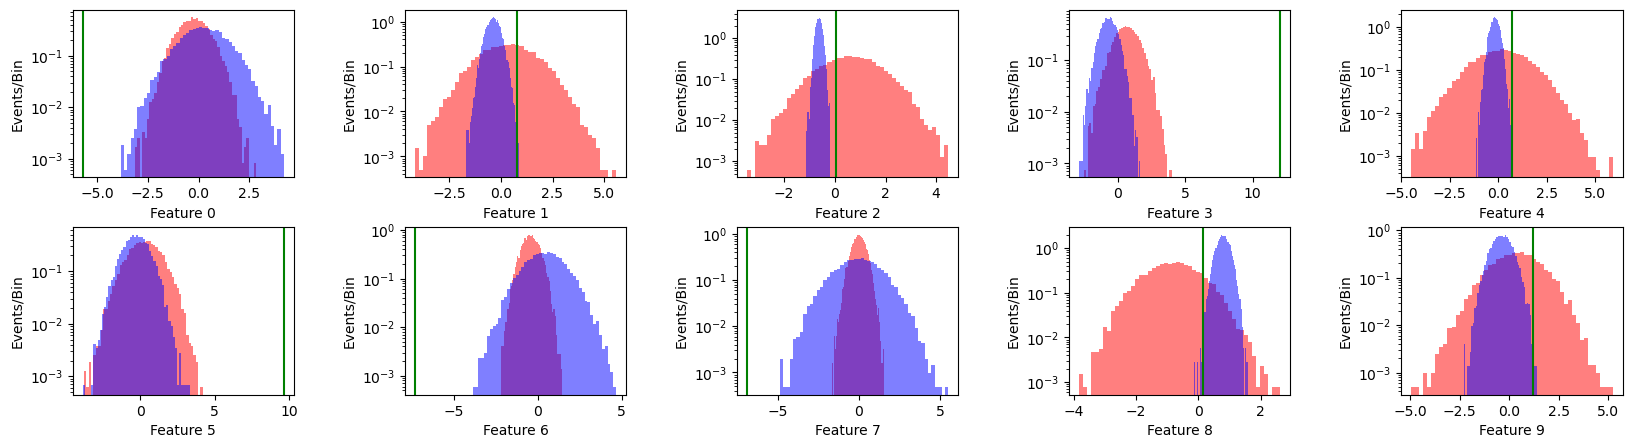

In [138]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net[0].bias.detach().numpy()
weights=net[0].weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = scaled_cuts[b], color='g')

In [ ]:
# Distributions before scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

cuts=sc.inverse_transform([scaled_cuts])[0]

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = cuts[b], color='g')

Now, what is this finding?  It's encoding the cut values in the weights and biases, but we need to evaluate the
efficiency of those cuts, not just the overall performance.

One tricky thing is whether these are "less than" cuts or "greater than" cuts.  The output of the network, prior to activation, should push background-like events to negative values, and signal-like events to positive values, such that the activation function maps them properly onto a zero-to-one range.  I think it's then enough to pass the event through the network and test if the values are less than or greater than zero.

Try a max(outputs) function, basically inf-norm.


In [ ]:
total_test=len(y_test)

num_pass_test=0
test_outputs = net(x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
falses=torch.tensor(m*[False])
for i in range(len(test_outputs)):
    #for j in range(m):
    #    if scaled_cuts[j]<0:
    #        if x_test_tensor[i][j]
    tt=0.5+torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)
    if i==1:
        print(x_test[i])
        print(y_test[i])
        print(x_test_tensor[i])
        print(test_outputs[i])
        print(torch.zeros(m))
        print(tt)
        print(t)
    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,falses) and y_test[i]==0.:
        num_pass_test+=1

effic_test = num_pass_test / total_test
print(effic_test)

# Now try a non-linear function

I don't think the below is working super well.  Losses look bad, and I'm not sure about the idea of just calling cuts passed/failed.

Maybe the thing to do above is to add an extra penalty if the cut is failed.  Currently there's a distance measure in there, but really we want the distance to be from the cut value.  

Right now the one above is computing the target as the linear transformation, and trying to push signal-like things towards 1 (backgr towards 0) for each feature.  That's good, but it's saying that it's just as good to push something that's very signal like to be very-very signal like as it is to push something that's not signal-like to something that's signal-like.  Maybe the point is we want a steeper activation function than a sigmoid, something more like (tanh(x)+1)/2.

Using tanh seems to do a bit better, maybe.

But OK, in some sense the cut value in the method above is zero, and we're pushing signal to positive values and background to negative values.  The bias is what allows the cut value to become zero.  That's why the bias/weight is the cut value.  So then the above really is giving us the distance from the cut value as the output, and we transform it with a sigmoid to allow us to use BCE.  Do we really want to use BCE as the final measure?  Maybe that's the real question.  Eventually we may want to use, for example, background rejection, or signal efficiency, or some combination of the two.

In any case, doing a binary selection as we do below doesn't seem to do a good job.  Probably has bugs, but I doubt this is the right approach at all.

In [439]:
class OneToOneBinary(torch.nn.Module):

    __constants__ = ['features']
    features: int
    weight: Tensor

    def __init__(self, features: int, 
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.features = features
        self.lowbound = Parameter(torch.empty(features, **factory_kwargs))
        #self.hghbound = Parameter(torch.empty(features, **factory_kwargs))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound=1./math.sqrt(self.features)
        torch.nn.init.uniform_(self.lowbound, -bound, bound)
        #torch.nn.init.uniform_(self.hghbound, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        targets = torch.autograd.Variable(torch.gt(input,self.lowbound).float(),requires_grad=True)
        #print(targets)
        return targets

    def extra_repr(self) -> str:
        return f'in_features={self.features}, bias={self.bias}'

In [440]:
torch.manual_seed(123)
net = OneToOneBinary(m)

torch.save(net.state_dict(), 'net.pth')

optimizer = torch.optim.Adam(net.parameters(), lr=0.2)

In [441]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(y_train)/1), shuffle=True)

for epoch in range(50):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        #print(y_pred.shape)
        #print(y_pred)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor, m)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.3s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  1 in  0.6s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  2 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  3 in  0.3s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  4 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  5 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  6 in  0.6s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  7 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  8 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch  9 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch 10 in  0.6s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch 11 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch 12 in  0.3s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch 13 in  0.2s, Train loss=6.8e-01, Test loss=6.8e-01
Completed epoch 14 in  0.3s, Train loss=6.8e-01, Test loss=6.8

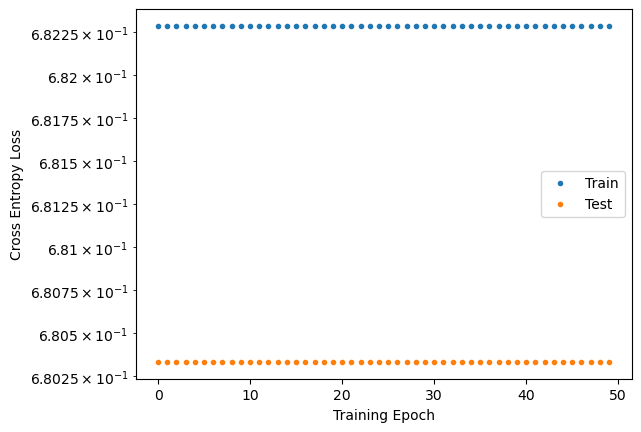

In [442]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

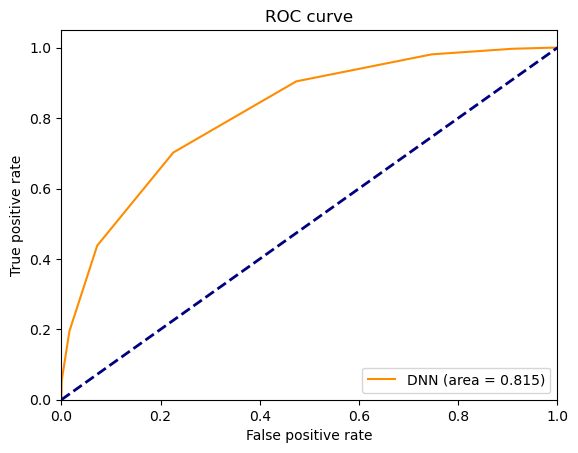

In [443]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = outputs_to_labels(net(x_test_tensor),m).detach().cpu()
y_pred_train= outputs_to_labels(net(x_train_tensor),m).detach().cpu()

fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

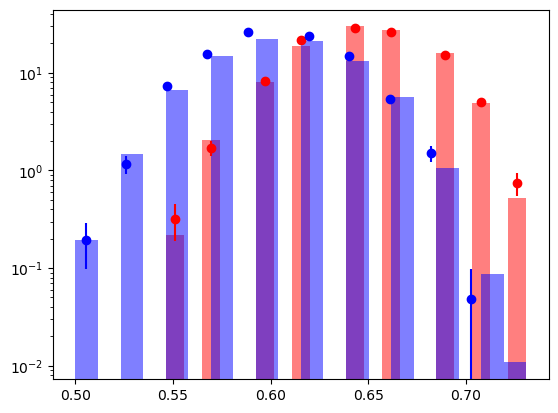

In [444]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
plt.yscale("log")
plt.show()

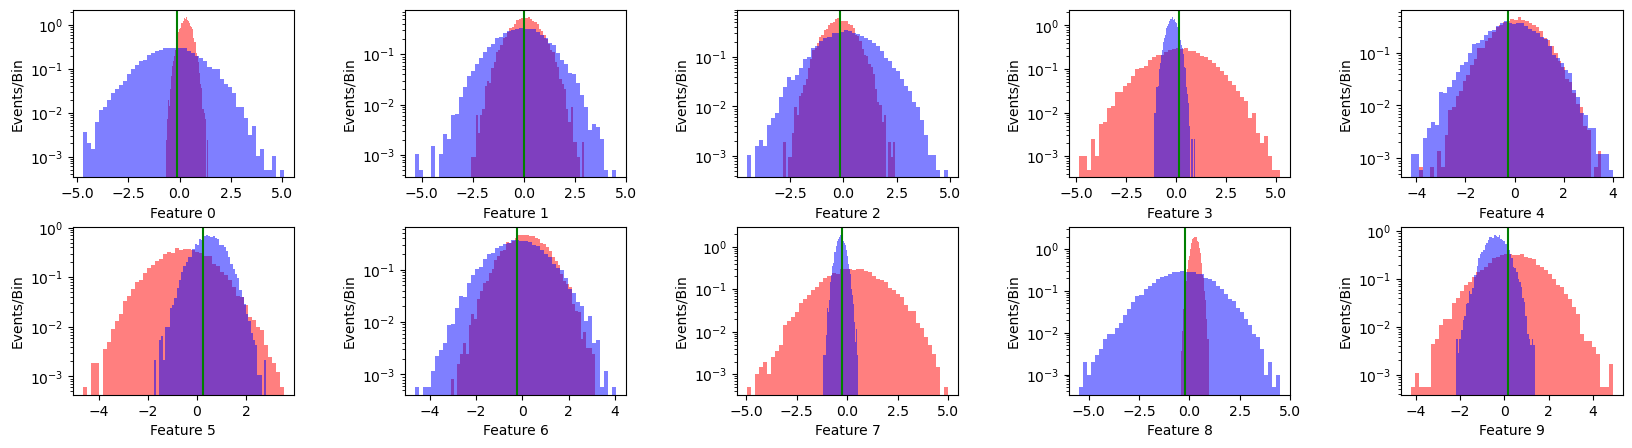

In [446]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

scaled_cuts=net.lowbound.detach().numpy()

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = scaled_cuts[b], color='g')